<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

--- 
# [kaggle] Классификация дорожных знаков

# Использование предобученных нейросетей (transfer learning)

## Работа с датасетом

Я расширил данный нам датасет данными из [семинара](https://drive.google.com/drive/folders/1kIunIYMII7XDx7VNP02Vk_uM8jqXGLkV) 9 недели.
 
Далее применил следующую аугментацию (добавил по 100 новых картинок в каждый из классов):

*   Random Erasing
*   Random Skew
*   Zoom

К классам:

*  120_SIGN
*  110_SIGN
*  80_SIGN
*  70_SIGN
*  60_SIGN
*  50_SIGN
*  30_SIGN




In [0]:
# for class_name in ['120_SIGN', '110_SIGN', '80_SIGN', '70_SIGN', '60_SIGN', '50_SIGN', '30_SIGN', ]:
#
#     p = Augmentor.Pipeline("data/"+class_name)
#
#     p.random_erasing(probability=0.5, rectangle_area=0.5)
#
#     p.skew_corner(probability=1, magnitude=0.5)
#     p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
#
#     p.sample(100)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/My\ Drive/ml/week_10/homework/aug_data.zip -d data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
data_path = 'data//data//'
# Путь, куда сохраним модель
model_save_path = 'gdrive/My Drive/ml/week_10/homework/signs_classifier.pth'

In [3]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
import torchvision
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time

print('Версия torch', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))
else:
    print('Using CPU')

Версия torch 1.1.0
Tesla T4


Ноутбук создан под версией torch '1.0.1'

### Создадим класс-обёртку для нашего датасета

In [0]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, transform=None, no_labels=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = pd.read_csv(csv_file)
        print(f'{len(self.signs_frame)} samples loaded')
        
        self.root_dir = root_dir
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
#         ])
        self.transform = transform
        self.no_labels = no_labels
        
        # В тестовом датасете нет ответов
        if not self.no_labels:
            # Cоздаём массив label->index и массив index->label
            self.labels = self.signs_frame['label'].unique()
            self.label_indexes = {}
            for i, label in enumerate(self.labels):
                self.label_indexes[label] = i

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        img_name = self.root_dir + self.signs_frame.iloc[idx, 0]
        image = Image.open(img_name)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        # Применим преобразования изображения (например аугментацию)
        if self.transform:
            image = self.transform(image)
            
        # Для тестового датасета не нужны ответы
        if not self.no_labels:
            # В роли ответа будем давать номер label
            label_string = self.signs_frame.iloc[idx, 1]
            label = self.label_indexes[label_string]
        
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image}
            
        return sample

### Создадим DataLoader'ы, облегчающие закрузку и сэмплинг данных

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

tdata_transform = transforms.Compose([
        transforms.Resize(50),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Инициализируем загрузчик датасета (класс выше)
dataset = SignsDataset(data_path + 'train.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor())

indicies = np.arange(len(dataset))

np.random.seed(0)
np.random.shuffle(indicies)

# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.8)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.2):])

# DataLoader достаёт данные из dataset батчами
signsTrainLoader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
signsValidationLoader = DataLoader(dataset, batch_size=32, sampler=validation_sampler)


6331 samples loaded


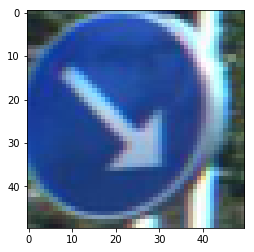

In [6]:
# Посмотрим, что выдаёт одна итерация DataLoader
batch = next(iter(signsTrainLoader))
img = batch['image'][0]
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)

### Датасет
Можно заметить, что данных стало на порядок больше за счет расширения и аугметнации


In [7]:
df = dataset.signs_frame
classes_number = df['label'].nunique()
print('Classes number:', classes_number)
df.groupby('label')['file_name'].nunique()

Classes number: 19


label
100_SIGN                    174
110_SIGN                    146
120_SIGN                    109
30_SIGN                     170
50_SIGN                     386
60_SIGN                     148
70_SIGN                     450
80_SIGN                     272
90_SIGN                      42
GIVE_WAY                    336
NO_PARKING                  140
NO_STOPPING_NO_STANDING     152
OTHER                       694
PASS_EITHER_SIDE             48
PASS_LEFT_SIDE                6
PASS_RIGHT_SIDE             778
PEDESTRIAN_CROSSING        1310
PRIORITY_ROAD               926
STOP                         44
Name: file_name, dtype: int64

## Создаём и обучаем сеть

In [0]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

Используем предобученную модель ResNet34

In [0]:
# Создаём сеть
cnn = torchvision.models.resnet34(pretrained=True).to(device)

In [25]:
cnn

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
cnn.classifier = nn.Linear(num_features, classes_number).to(device)


In [0]:
# Добавляем режимы обучения и валидации
dataloaders = {"train": signsTrainLoader, "val": signsValidationLoader}
datasets = {"train": train_sampler, "val": validation_sampler}

# Выбираем алгоритм оптимизации и learning_rate
learning_rate = 3e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Функция для обучения модели
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = {'loss':[], 'val_loss':[]}
    
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:     
            since_epoch = time.time()
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs = data['image'].to(device)
                labels = data['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statistics
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects / len(datasets[phase])
            
            if phase == 'train':
                history['loss'].append(loss.item())
            else:
                history['val_loss'].append(loss.item())

            time_elapsed_epoch = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} in {:.0f}m {:.0f}s'.format(
                phase, epoch_loss, epoch_acc, time_elapsed_epoch // 60, time_elapsed_epoch % 60))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, model_save_path)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return history, model

In [30]:
history, cnn = train_model(cnn, loss_fn, optimizer, exp_lr_scheduler,
                           num_epochs=20)

Epoch 0/19
----------
train Loss: 0.0568 Acc: 0.7948 in 0m 13s
val Loss: 0.0065 Acc: 0.9396 in 0m 4s

Epoch 1/19
----------
train Loss: 0.0133 Acc: 0.9376 in 0m 13s
val Loss: 0.0019 Acc: 0.9793 in 0m 5s

Epoch 2/19
----------
train Loss: 0.0067 Acc: 0.9716 in 0m 13s
val Loss: 0.0013 Acc: 0.9885 in 0m 4s

Epoch 3/19
----------
train Loss: 0.0049 Acc: 0.9763 in 0m 13s
val Loss: 0.0008 Acc: 0.9905 in 0m 4s

Epoch 4/19
----------
train Loss: 0.0036 Acc: 0.9858 in 0m 13s
val Loss: 0.0014 Acc: 0.9852 in 0m 5s

Epoch 5/19
----------
train Loss: 0.0028 Acc: 0.9872 in 0m 13s
val Loss: 0.0010 Acc: 0.9917 in 0m 4s

Epoch 6/19
----------
train Loss: 0.0014 Acc: 0.9939 in 0m 13s
val Loss: 0.0004 Acc: 0.9964 in 0m 4s

Epoch 7/19
----------
train Loss: 0.0006 Acc: 0.9980 in 0m 13s
val Loss: 0.0003 Acc: 0.9974 in 0m 4s

Epoch 8/19
----------
train Loss: 0.0003 Acc: 0.9994 in 0m 13s
val Loss: 0.0003 Acc: 0.9970 in 0m 4s

Epoch 9/19
----------
train Loss: 0.0003 Acc: 0.9994 in 0m 13s
val Loss: 0.0003 Ac

#### [Ссылка](https://drive.google.com/drive/folders/1DGdz27j9L77bRvqYErZdapQrUbndTSD1?usp=sharing) на сохраненную и обученную модель для воспроизведения полученного скора

### Начертим кривые обучения

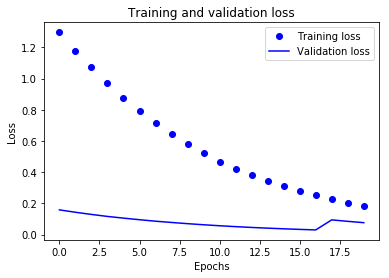

In [31]:
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['loss'])
val_loss_values = smooth_curve(history['val_loss'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Выведем confusion matrix

In [0]:
import itertools
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

Normalized confusion matrix


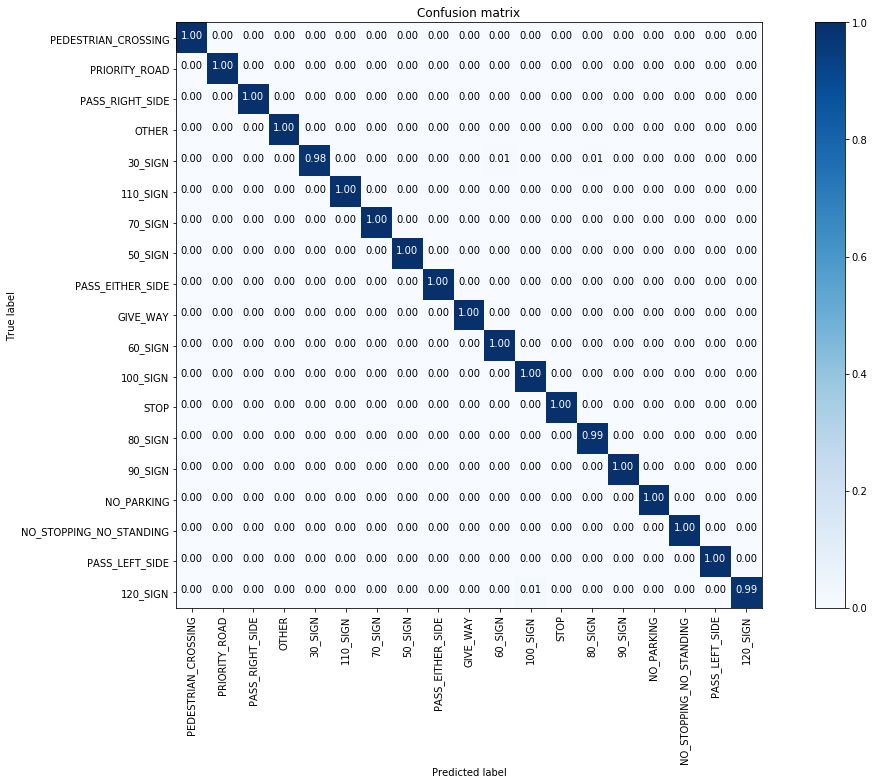

In [33]:
from sklearn.metrics import confusion_matrix

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for batch in signsValidationLoader:
        predictions = cnn(batch['image'].to(device))
        y_test = batch['label']
        _, predictions = torch.max(predictions.cpu(), 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_test), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

feature_names = signsTrainLoader.dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
# Выведем её
plot_confusion_matrix(cm, dataset.labels, normalize=True)

### Задача
    - какие выводы можно сделать из confusion matrix?

### Выведем точность для каждого класса

In [34]:
class_correct = [0 for i in range(classes_number)]
class_total = [0 for i in range(classes_number)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total)

for i in range(classes_number):
    print('Accuracy of %5s : %2d %%' % (
        (dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[1058, 729, 640, 550, 132, 108, 370, 297, 37, 262, 125, 146, 36, 218, 34, 115, 120, 4, 84]
Accuracy of PEDESTRIAN_CROSSING : 99 %
Accuracy of PRIORITY_ROAD : 100 %
Accuracy of PASS_RIGHT_SIDE : 100 %
Accuracy of OTHER : 99 %
Accuracy of 30_SIGN : 98 %
Accuracy of 110_SIGN : 100 %
Accuracy of 70_SIGN : 99 %
Accuracy of 50_SIGN : 100 %
Accuracy of PASS_EITHER_SIDE : 100 %
Accuracy of GIVE_WAY : 100 %
Accuracy of 60_SIGN : 100 %
Accuracy of 100_SIGN : 100 %
Accuracy of  STOP : 100 %
Accuracy of 80_SIGN : 99 %
Accuracy of 90_SIGN : 100 %
Accuracy of NO_PARKING : 100 %
Accuracy of NO_STOPPING_NO_STANDING : 100 %
Accuracy of PASS_LEFT_SIDE : 100 %
Accuracy of 120_SIGN : 98 %


### Оценим качество на отдельных кадрах из validation'а

Gound-true: PEDESTRIAN_CROSSING
Prediction: PEDESTRIAN_CROSSING


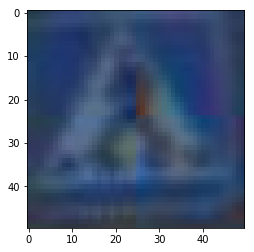

In [35]:
batch = next(iter(signsValidationLoader))
predictions = cnn(batch['image'].to(device))
y_test = batch['label']


#print(predictions, y_test)
_, predictions = torch.max(predictions, 1)

img = batch['image'][0]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

print('Gound-true:', dataset.labels[batch['label'][0]])
print('Prediction:', dataset.labels[predictions[0]])

# Генерация файла ответов на test

In [36]:
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
test_dataset = SignsDataset('test.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor(),
                       no_labels=True)


# DataLoader достаёт данные из dataset батчами
signsTestLoader = DataLoader(test_dataset, batch_size=1)

610 samples loaded


In [0]:
answer = []

for batch in signsTestLoader:
    predictions = cnn(batch['image'].to(device))
    _, predictions = torch.max(predictions, 1)
    answer.append(dataset.labels[predictions[0]])    

prediction_df = test_dataset.signs_frame
    
prediction_df['label'] = pd.Series(answer)
prediction_df.to_csv('my_submission.csv', index=False)